# Imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.optim.lr_scheduler import ExponentialLR
from torch.distributions import MultivariateNormal, Categorical
import numpy as np
import random
import gymnasium as gym
from gymnasium.spaces import Box
from gymnasium.wrappers import FrameStackObservation, TimeLimit, ResizeObservation, RecordVideo, MaxAndSkipObservation, GrayscaleObservation
from collections import deque
import retro
import io
import time
import os
import gc
import pandas as pd
from stable_baselines3.common.monitor import Monitor
from torch.amp import autocast, GradScaler

# Variables

In [3]:
RENDER_ENV = False
RESIZE_ENV = False
LOAD_MODEL = False
RGB = False
FRAMESTACK = True
Render_Frame_rate=4
new_size = (84,120) #Original Size 320, 224
num_episodes = 200
max_steps_per_episode = 1800
num_stacked_frames = 4
num_frame_skip = 4
Model = "D3QN"
save_interval = 100
episode_p_interval = 4
rew_p_interval = 900

#Version
version = 8

#Hiperparametros
LR = 2e-5
GAMMA = 0.999

#DQN y D3QN Params
EPSILON = 1.0
EPSILON_DECAY = 0.01#0.99 Exponential / 0.01 Reciprocal
BUFFER_SIZE = 20000
batch_size = 256
EPSILON_END = 0.01

#D3QN
UPDATE_TARGET_FREQ = 10000

#PPO Params
N_STEPS = 1024
N_UPDATES_PER_ITERATION = 5
CLIP = 0.1
ENTROPY_COEF = 0.01



# Functions

## Utils

In [7]:
def get_last_modified_file(directory_path):
    if not os.path.isdir(directory_path):
        print(f"Error: Directory '{directory_path}' does not exist.")
        return None
    files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]
    if not files:
        return None
    files.sort(key=os.path.getmtime, reverse=True)
    return files[0]

target_directory = f"../Saved_Models/{Model}"  # Replace with your directory path
model_load_path = get_last_modified_file(target_directory)

if model_load_path:
    print(f"The last modified file is: {model_load_path}")
else:
    print("No files found in the directory or directory does not exist.")

The last modified file is: ../Saved_Models/D3QN/D3QN-Sonic-V8-E200-S1800.pth


In [8]:
try:
    os.mkdir("../Saved_Models")
except Exception as e:
    print(f"Error: {e}")

try:
    os.mkdir("../Saved_Models/PPO")
except Exception as e:
    print(f"Error: {e}")

try:
    os.mkdir("../Saved_Models/PPO/Actor")
except Exception as e:
    print(f"Error: {e}")

try:
    os.mkdir("../Saved_Models/PPO/Critic")
except Exception as e:
    print(f"Error: {e}")

try:
    os.mkdir("../Saved_Models/DQN")
except Exception as e:
    print(f"Error: {e}")

try:
    os.mkdir("../Saved_Models/D3QN")
except Exception as e:
    print(f"Error: {e}")

try:
    os.mkdir("../Video")
except Exception as e:
    print(f"Error: {e}")

try:
    os.mkdir("../Video/PPO")
except Exception as e:
    print(f"Error: {e}")
    
try:
    os.mkdir("../Video/DQN")
except Exception as e:
    print(f"Error: {e}")

try:
    os.mkdir("../Video/D3QN")
except Exception as e:
    print(f"Error: {e}")

try:
    os.mkdir("../Logs/PPO")
except Exception as e:
    print(f"Error: {e}")
    
try:
    os.mkdir("../Logs/DQN")
except Exception as e:
    print(f"Error: {e}")

try:
    os.mkdir("../Logs/D3QN")
except Exception as e:
    print(f"Error: {e}")

Error: [Errno 17] File exists: '../Saved_Models'
Error: [Errno 17] File exists: '../Saved_Models/PPO'
Error: [Errno 17] File exists: '../Saved_Models/PPO/Actor'
Error: [Errno 17] File exists: '../Saved_Models/PPO/Critic'
Error: [Errno 17] File exists: '../Saved_Models/DQN'
Error: [Errno 17] File exists: '../Saved_Models/D3QN'
Error: [Errno 17] File exists: '../Video'
Error: [Errno 17] File exists: '../Video/PPO'
Error: [Errno 17] File exists: '../Video/DQN'
Error: [Errno 17] File exists: '../Video/D3QN'
Error: [Errno 17] File exists: '../Logs/PPO'
Error: [Errno 17] File exists: '../Logs/DQN'
Error: [Errno 17] File exists: '../Logs/D3QN'


In [9]:
#Guardar Modelo
def save_model(agent, episode):
    model_save_path = f'../Saved_Models/{Model}' #ppt para jit, pth para statedict
    model_file_name = f'/{Model}-Sonic-V{version}-E{episode}-S{max_steps_per_episode}.pth'
    try:
        if Model == "PPO":
            torch.save(agent.model_actor.state_dict(), model_save_path+"/Actor"+model_file_name)
            torch.save(agent.model_critic.state_dict(), model_save_path+"/Critic"+model_file_name)
        else:
            torch.save(agent.model_online.state_dict(), model_save_path+model_file_name)
        #torch.save(agent.model, model_save_path)
        print(f'Modelo exitosamente guardado en {model_save_path}')
    except Exception as e:
        print(f'Error guardando el modelo error: {e}')

In [10]:
class ButtonActionWrapper(gym.ActionWrapper):
    """
    Wrap a gym-retro environment and make it use discrete
    actions for the Sonic game.
    """
    def __init__(self, env):
        super(ButtonActionWrapper, self).__init__(env)
        buttons = env.unwrapped.buttons
        actions = [['LEFT'], ['RIGHT'], ['LEFT', 'DOWN'], ['RIGHT', 'DOWN'], ['DOWN'],
                   ['DOWN', 'B'], ['B']]
        self._actions = []
        for action in actions:
            arr = np.array([False] * env.action_space.n)
            for button in action:
                arr[buttons.index(button)] = True
            self._actions.append(arr)
        self.action_space = gym.spaces.Discrete(len(self._actions))

    def action(self, a): # pylint: disable=W0221
        return self._actions[a].copy()

In [11]:
class CustomRewardWrapper(gym.RewardWrapper):
    def __init__(self, env, mov_rew=1, score_rew=1, hp_rew=1, ring_rew=0.5, end_bonus=100):
        super(CustomRewardWrapper, self).__init__(env)
        self.mov_rew = mov_rew
        self.score_rew = score_rew
        self.hp_rew = hp_rew
        self.ring_rew = ring_rew
        self.end_bonus = end_bonus

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        game_variables = self.env.unwrapped.data.lookup_all()

        self.previous_pos_x = game_variables['x']
        self.previous_score = game_variables['score']
        self.previous_lives = game_variables['lives']
        self.previous_rings = game_variables['rings']
        self.previous_end_bonus = game_variables['level_end_bonus']

        return obs, info

    def reward(self, reward):
        #print(f"Reward original: {reward}")
        custom_reward = reward
        game_state = self.env.unwrapped.data

        if game_state:
            game_variables = game_state.lookup_all()
            current_pos_x = game_variables['x']
            current_score = game_variables['score']
            current_lives = game_variables['lives']
            current_rings = game_variables['rings']
            current_end_bonus = game_variables['level_end_bonus']

            # moverse hacia la derecha
            if current_pos_x > self.previous_pos_x:
                #Recompensa
                custom_reward += self.mov_rew
            else:
                #Penalizacion
                custom_reward -= self.mov_rew

            #Recompensa por puntaje
            if current_score > self.previous_score:
                custom_reward += self.score_rew*(current_score-self.previous_score)
            
            #Recompensa por ganar vida
            if current_lives > self.previous_lives:
                custom_reward += self.hp_rew*(current_lives-self.previous_lives)

            #Penalizacion por perder vida
            if current_lives < self.previous_lives:
                custom_reward += (self.hp_rew/2)*(current_lives-self.previous_lives)

            #Recompensa por conseguir anillos
            if current_rings > self.previous_rings:
                custom_reward += self.ring_rew*(current_rings-self.previous_rings)
            
            #Penalizacion por perder anillos
            if current_rings < self.previous_rings:
                custom_reward += (self.ring_rew/2)*(current_rings-self.previous_rings)

            #Recompensa por completar nivel
            if current_end_bonus > self.previous_end_bonus:
                custom_reward += self.end_bonus

            self.previous_pos_x = current_pos_x
            self.previous_score = current_score
            self.previous_lives = current_lives
            self.previous_rings = current_rings
            self.previous_end_bonus = current_end_bonus


        return custom_reward

In [12]:
class StochasticFrameSkip(gym.Wrapper):
    def __init__(self, env, n, stickprob):
        gym.Wrapper.__init__(self, env)
        self.n = n
        self.stickprob = stickprob
        self.curac = None
        self.rng = np.random.RandomState()
        self.supports_want_render = hasattr(env, "supports_want_render")

    def reset(self, **kwargs):
        self.curac = None
        return self.env.reset(**kwargs)

    def step(self, ac):
        terminated = False
        truncated = False
        totrew = 0
        for i in range(self.n):
            # First step after reset, use action
            if self.curac is None:
                self.curac = ac
            # First substep, delay with probability=stickprob
            elif i == 0:
                if self.rng.rand() > self.stickprob:
                    self.curac = ac
            # Second substep, new action definitely kicks in
            elif i == 1:
                self.curac = ac
            if self.supports_want_render and i < self.n - 1:
                ob, rew, terminated, truncated, info = self.env.step(
                    self.curac,
                    want_render=False,
                )
            else:
                ob, rew, terminated, truncated, info = self.env.step(self.curac)
            totrew += rew
            if terminated or truncated:
                break
        return ob, totrew, terminated, truncated, info

In [13]:
def make_env(*, game, state=None, max_episode_steps=4500,log_mon = False, **kwargs):
    if state is None:
        state = retro.State.DEFAULT
    env = retro.make(game, state, **kwargs)
    env = ButtonActionWrapper(env)
    #env = CustomRewardWrapper(env)
    env = StochasticFrameSkip(env, n=num_frame_skip, stickprob=0.25)
    if RGB:
        channels = 3
    else:
        env = GrayscaleObservation(env)
        channels = 1
    if RESIZE_ENV:
        input_shape = (num_stacked_frames*channels, *new_size)
        env = ResizeObservation(env, new_size)
    else:
        input_shape = (num_stacked_frames*channels, 224, 320)
    if FRAMESTACK:
        env = FrameStackObservation(env, stack_size=num_stacked_frames)
    if max_episode_steps is not None:
        env = TimeLimit(env, max_episode_steps=max_episode_steps)
    if log_mon:
        env = Monitor(env, f'../Logs/{Model}/{Model}_V{version}_S{num_episodes*max_steps_per_episode}.csv')
    return env, input_shape

## Replay Buffer

In [14]:
class Replay_Buffer:
    def __init__(self, buffer_size):
        self.memory = deque(maxlen=buffer_size)  
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    def add(self, experience):
        e = self.experience(*experience)
        self.memory.append(e)
    def sample(self, batch_size):
        experiences = random.sample(self.memory, k=batch_size)
        minibatch_compatible = [[e] for e in experiences]
        tree_indices = None 
        is_weights = None
        return tree_indices, minibatch_compatible, is_weights
    def __len__(self):
        return len(self.memory)
    def batch_update(self, tree_idx, abs_errors):
        pass

## PrioritizedExperienceReplay

In [15]:
class SumTree(object):
    data_pointer = 0
    
    def __init__(self, capacity):
        self.capacity = capacity 
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.current_size = 0
        
    def add(self, priority, data):
        tree_index = self.data_pointer + self.capacity - 1
        self.data[self.data_pointer] = data
        self.update (tree_index, priority)
        if self.current_size < self.capacity:
            self.current_size += 1
        self.data_pointer += 1
        if self.data_pointer >= self.capacity:  
            self.data_pointer = 0
            
    def update(self, tree_index, priority):
        change = priority - self.tree[tree_index]
        self.tree[tree_index] = priority
        while tree_index != 0: 
            tree_index = (tree_index - 1) // 2
            self.tree[tree_index] += change
            
    def get_leaf(self, v):
        parent_index = 0
        while True: 
            left_child_index = 2 * parent_index + 1
            right_child_index = left_child_index + 1
            if left_child_index >= len(self.tree):
                leaf_index = parent_index
                break
            else: 
                if v <= self.tree[left_child_index]:
                    parent_index = left_child_index
                else:
                    v -= self.tree[left_child_index]
                    parent_index = right_child_index
        data_index = leaf_index - self.capacity + 1
        return leaf_index, self.tree[leaf_index], self.data[data_index]
        
    @property
    def total_priority(self):
        return self.tree[0] 

In [16]:
class PrioritizedExperienceReplay:
    PER_e = 0.01  
    PER_a = 0.6  
    PER_b = 0.4  
    PER_b_increment_per_sampling = 0.001
    absolute_error_upper = 1.  
        
    def __init__(self, capacity):
        self.tree = SumTree(capacity)
        
    def add(self, experience):
        # Find the max priority
        max_priority = np.max(self.tree.tree[-self.tree.capacity:])
        if max_priority == 0:
            max_priority = self.absolute_error_upper
        self.tree.add(max_priority, experience)   
        
    def sample(self, n):
        memory_b = []
        b_idx, b_ISWeights = np.empty((n,), dtype=np.int32), np.empty((n, 1), dtype=np.float32)
        priority_segment = self.tree.total_priority / n 
        self.PER_b = np.min([1., self.PER_b + self.PER_b_increment_per_sampling]) 
        
        filled_priorities = self.tree.tree[-self.tree.capacity:][:self.tree.current_size]
        if len(filled_priorities) > 0 and self.tree.total_priority > 0:
            p_min = np.min(filled_priorities) / self.tree.total_priority
        else:
            p_min = 1e-8
        
        if p_min == 0 or p_min * n == 0:
            p_min = 1e-8
            
        max_weight = (p_min * n) ** (-self.PER_b)
        
        for i in range(n):
            a, b = priority_segment * i, priority_segment * (i + 1)
            value = np.random.uniform(a, b)
            index, priority, data = self.tree.get_leaf(value)
            sampling_probabilities = priority / self.tree.total_priority
            b_ISWeights[i, 0] = np.power(n * sampling_probabilities, -self.PER_b)/ max_weight
            b_idx[i]= index
            experience = [data]
            memory_b.append(experience)
        return b_idx, memory_b, b_ISWeights
        
    def batch_update(self, tree_idx, abs_errors):
        abs_errors += self.PER_e
        clipped_errors = np.minimum(abs_errors, self.absolute_error_upper)
        ps = np.power(clipped_errors, self.PER_a)
        for ti, p in zip(tree_idx, ps):
            self.tree.update(ti, p)
    def __len__(self):
        return self.tree.current_size

# Models & Agents

## DQN

In [17]:
class ConvDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(ConvDQN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(self.calc_conv_output(input_shape), 512),
            nn.ReLU(),
            nn.Linear(512, num_actions)
        )

    def calc_conv_output(self, shape):
        dummy_input = torch.zeros(1, *shape)
        dummy_output = self.conv_layers(dummy_input)
        return int(np.prod(dummy_output.size()))

    def forward(self, x):
        conv_out = self.conv_layers(x).view(x.size()[0], -1)
        return self.fc_layers(conv_out)

In [18]:
class ConvDQNAgent:
    def __init__(self, env, input_shape, num_actions, buffer_class, lr = 1e-4, gamma = 0.99, epsilon = 1.0, epsilon_decay = 0.99, buffer_size = 10000, update_target_freq=10000, epsilon_end=0.01):
        self.env = env
        self.input_shape = input_shape
        self.num_actions = num_actions
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.st = epsilon_end-((epsilon-epsilon_end)*(100.0/(1.0+epsilon_decay*180000.0)))
        self.memory = buffer_class(buffer_size)
        self.device = 'cuda'
        self.model_online = ConvDQN(input_shape, num_actions).to(self.device)
        self.model_target = ConvDQN(input_shape, num_actions).to(self.device)
        self.model_target.load_state_dict(self.model_online.state_dict())
        self.optimizer = optim.Adam(self.model_online.parameters(), lr=lr)
        self.update_target_freq = update_target_freq
        self.step_counter = 0
        self.epsilon_end = epsilon_end
        self.epsilon_start = epsilon
        self.decay_steps = 0
        self.scaler = GradScaler(self.device)
    
    def preprocess_wv(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32, device=self.device) / 255.0
        if RGB and FRAMESTACK:
            state_tensor = state_tensor.permute(0, 3, 1, 2) 
            C_out = self.input_shape[0]
            H_out = self.input_shape[1] 
            W_out = self.input_shape[2] 
            state_tensor = state_tensor.contiguous().view(C_out, H_out, W_out)
        return state_tensor
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.num_actions)
        state = self.preprocess_wv(state)
        with torch.no_grad():
            q_values = self.model_online(state.unsqueeze(0))
        return torch.argmax(q_values).item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.add((state, action, reward, next_state, done))
        
    def update_target_network(self):
        if self.step_counter % self.update_target_freq == 0:
            self.model_target.load_state_dict(self.model_online.state_dict())

    def replay_vect(self, batch_size):
        if len(self.memory) < batch_size:
            return
        tree_indices, minibatch, IS_weights = self.memory.sample(batch_size)
        experiences = [item[0] for item in minibatch]
        states, actions, rewards, next_states, dones = zip(*experiences)
        states_tensor = torch.stack([self.preprocess_wv(s) for s in states])
        next_states_tensor = torch.stack([self.preprocess_wv(ns) for ns in next_states])
        actions_tensor = torch.tensor(actions, dtype=torch.long, device=self.device)
        rewards_tensor = torch.tensor(rewards, dtype=torch.float32, device=self.device)
        dones_tensor = torch.tensor(dones, dtype=torch.bool, device=self.device)
        if IS_weights is not None:
            IS_weights_tensor = torch.tensor(IS_weights, dtype=torch.float32, device=self.device)
        with torch.no_grad():
            next_q_values_target = self.model_target(next_states_tensor)
            max_Q_next = torch.max(next_q_values_target, dim=1).values
            target_q_values = rewards_tensor + self.gamma * max_Q_next * (~dones_tensor)
        
        with autocast(device_type=self.device):
            current_q_values = self.model_online(states_tensor)
            current_q_for_actions = current_q_values.gather(1, actions_tensor.unsqueeze(1)).squeeze()
            if IS_weights is not None:
                loss = (IS_weights_tensor.squeeze() * nn.MSELoss(reduction='none')(current_q_for_actions, target_q_values)).mean()
            else:
                loss = nn.MSELoss()(current_q_for_actions, target_q_values)
        
        td_error = torch.abs(target_q_values - current_q_for_actions).detach().cpu().numpy()

        self.optimizer.zero_grad()
        self.scaler.scale(loss).backward()
        self.scaler.unscale_(self.optimizer)
        torch.nn.utils.clip_grad_norm_(self.model_online.parameters(), max_norm=10.0)
        self.scaler.step(self.optimizer)
        self.scaler.update()
        
        self.memory.batch_update(tree_indices, td_error)
        
        self.step_counter += 1
        self.update_target_network()
        
        self.decay()
        

    def learn(self, total_timesteps):
        temp_reward = 0
        frame_count_prev = 0
        frame_count = 0
        ep_count = 0
        while frame_count < total_timesteps:
            state, _ = self.env.reset()
            total_reward = 0
            done = False
            ep_count += 1
            while not done:
                frame_count += 1
                action = self.act(state = state)
                observation, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                self.remember(state, action, reward, observation, done)
                state = observation
                total_reward += reward
                temp_reward += reward
                if frame_count % rew_p_interval == 0:
                    print(f'step n={frame_count} with reward {temp_reward}')
                    temp_reward = 0
                if frame_count % 4 == 0:
                    #for _ in range(4):
                    self.replay_vect(batch_size)

            if (ep_count+1) % episode_p_interval == 0:
                print(f'Episode {ep_count+1} \nstep n={(frame_count-frame_count_prev)/episode_p_interval}\nreward {temp_reward/episode_p_interval}\n')
                temp_reward = 0
                frame_count_prev=frame_count
            if (ep_count+1) % save_interval == 0:
                save_model(self, ep_count)
            print(f"Episode finished with total reward: {total_reward}")
    def decay(self):
        self.decay_steps += 1
        if self.epsilon > self.epsilon_end:
            if self.epsilon_decay > 0.5:
                self.epsilon *= self.epsilon_decay
            else:
                self.epsilon = max(self.epsilon_end,self.st+((self.epsilon_start-self.epsilon_end)*(100.0/(1.0+self.epsilon_decay*self.decay_steps))))
         

## D3QN

In [19]:
class ConvD3QN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(ConvD3QN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.advance_stream = nn.Sequential(
            nn.Linear(self.calc_conv_output(input_shape), 512),
            nn.ReLU(),
            nn.Linear(512, num_actions)
        )
        self.value_stream = nn.Sequential(
            nn.Linear(self.calc_conv_output(input_shape), 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

    def calc_conv_output(self, shape):
        dummy_input = torch.zeros(1, *shape)
        dummy_output = self.conv_layers(dummy_input)
        return int(np.prod(dummy_output.size()))

    def forward(self, x):
        conv_out = self.conv_layers(x).view(x.size()[0], -1)
        advantages = self.advance_stream(conv_out)
        value = self.value_stream(conv_out)
        q_values = value + (advantages - advantages.mean(dim=1, keepdim=True))
        return q_values

In [20]:
class ConvD3QNAgent:
    def __init__(self, env, input_shape, num_actions, buffer_class, lr = 1e-4, gamma = 0.99, epsilon = 1.0, epsilon_decay = 0.99, buffer_size = 10000, update_target_freq=10000, epsilon_end = 0.01):
        self.env = env
        self.input_shape = input_shape
        self.num_actions = num_actions
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.st = epsilon_end-((epsilon-epsilon_end)*(100.0/(1.0+epsilon_decay*180000.0)))
        self.memory = buffer_class(buffer_size)
        self.device = 'cuda'
        self.model_online = ConvD3QN(input_shape, num_actions).to(self.device)
        self.model_target = ConvD3QN(input_shape, num_actions).to(self.device)
        self.model_target.load_state_dict(self.model_online.state_dict())
        self.optimizer = optim.Adam(self.model_online.parameters(), lr=lr)
        self.update_target_freq = update_target_freq
        self.step_counter = 0
        self.epsilon_end = epsilon_end
        self.epsilon_start = epsilon
        self.decay_steps = 0
        self.scaler = GradScaler(self.device)
    
    def preprocess_wv(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32, device=self.device)
        state_tensor = state_tensor / 255.0
        if RGB and FRAMESTACK:
            state_tensor = state_tensor.permute(0, 3, 1, 2) 
            C_out = self.input_shape[0]
            H_out = self.input_shape[1] 
            W_out = self.input_shape[2] 
            state_tensor = state_tensor.contiguous().view(C_out, H_out, W_out)
        return state_tensor
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.num_actions)
        state = self.preprocess_wv(state)
        with torch.no_grad():
            q_values = self.model_online(state.unsqueeze(0))
        return torch.argmax(q_values).item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.add((state, action, reward, next_state, done))

    def replay_vect(self, batch_size):
        if len(self.memory) < batch_size:
            return
        tree_indices, minibatch, IS_weights = self.memory.sample(batch_size)
        experiences = [item[0] for item in minibatch]
        states, actions, rewards, next_states, dones = zip(*experiences)
        states_tensor = torch.stack([self.preprocess_wv(s) for s in states])
        next_states_tensor = torch.stack([self.preprocess_wv(ns) for ns in next_states])
        actions_tensor = torch.tensor(actions, dtype=torch.long, device=self.device)
        rewards_tensor = torch.tensor(rewards, dtype=torch.float32, device=self.device)
        dones_tensor = torch.tensor(dones, dtype=torch.bool, device=self.device)
        if IS_weights is not None:
            IS_weights_tensor = torch.tensor(IS_weights, dtype=torch.float32, device=self.device)
        with torch.no_grad():
            next_q_values_online = self.model_online(next_states_tensor)
            best_action_online_indices = torch.argmax(next_q_values_online, dim=1).unsqueeze(1)
            max_Q_next = self.model_target(next_states_tensor).gather(1, best_action_online_indices).squeeze()
        target_q_values = rewards_tensor + self.gamma * max_Q_next * (~dones_tensor)

        with autocast(device_type=self.device):
            current_q_values = self.model_online(states_tensor)
            current_q_for_actions = current_q_values.gather(1, actions_tensor.unsqueeze(1)).squeeze()
            if IS_weights is not None:
                loss = (IS_weights_tensor.squeeze() * nn.MSELoss(reduction='none')(current_q_for_actions, target_q_values)).mean()
            else:
                loss = nn.MSELoss()(current_q_for_actions, target_q_values)
                
        td_error = torch.abs(target_q_values - current_q_for_actions).detach().cpu().numpy()
        
        self.optimizer.zero_grad()
        self.scaler.scale(loss).backward()
        self.scaler.unscale_(self.optimizer)
        torch.nn.utils.clip_grad_norm_(self.model_online.parameters(), max_norm=10.0)
        self.scaler.step(self.optimizer)
        self.scaler.update()
        
        self.memory.batch_update(tree_indices, td_error)
        
        self.step_counter += 1
        self.update_target_network()
        
        self.decay()
    
    def update_target_network(self):
        if self.step_counter % self.update_target_freq == 0:
            self.model_target.load_state_dict(self.model_online.state_dict())

    def learn(self, total_timesteps):
        temp_reward = 0
        frame_count_prev = 0
        frame_count = 0
        ep_count = 0
        while frame_count < total_timesteps:
            state, _ = self.env.reset()
            total_reward = 0
            done = False
            ep_count += 1
            while not done:
                frame_count += 1
                action = self.act(state = state)
                observation, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                self.remember(state, action, reward, observation, done)
                state = observation
                total_reward += reward
                temp_reward += reward
                if frame_count % rew_p_interval == 0:
                    print(f'step n={frame_count} with reward {temp_reward}')
                    temp_reward = 0
                if frame_count % 4 == 0:
                    #for _ in range(4):
                    self.replay_vect(batch_size)

            if (ep_count+1) % episode_p_interval == 0:
                print(f'Episode {ep_count+1} \nstep n={(frame_count-frame_count_prev)/episode_p_interval}\nreward {temp_reward/episode_p_interval}\n')
                temp_reward = 0
                frame_count_prev=frame_count
            if (ep_count+1) % save_interval == 0:
                save_model(self, ep_count)
            print(f"Episode finished with total reward: {total_reward}")
            
    def decay(self):
        self.decay_steps += 1
        if self.epsilon > self.epsilon_end:
            if self.epsilon_decay > 0.5:
                self.epsilon *= self.epsilon_decay
            else:
                self.epsilon = max(self.epsilon_end,self.st+((self.epsilon_start-self.epsilon_end)*(100.0/(1.0+self.epsilon_decay*self.decay_steps))))

## PPO

In [21]:
class ConvPPOActor(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(ConvPPOActor, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.LeakyReLU()
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(self.calc_conv_output(input_shape), 512),
            nn.LeakyReLU(),
            nn.Linear(512, num_actions),
            #nn.Softmax(dim=1)
        )

    def calc_conv_output(self, shape):
        dummy_input = torch.zeros(1, *shape)
        dummy_output = self.conv_layers(dummy_input)
        return int(np.prod(dummy_output.size()))

    def forward(self, x):
        conv_out = self.conv_layers(x).view(x.size()[0], -1)
        conv_out = self.fc_layers(conv_out)
        dist = Categorical(logits=conv_out)
        return dist
    
class ConvPPOCritic(nn.Module):
    def __init__(self, input_shape):
        super(ConvPPOCritic, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.LeakyReLU()
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(self.calc_conv_output(input_shape), 512),
            nn.LeakyReLU(),
            nn.Linear(512, 1)
        )

    def calc_conv_output(self, shape):
        dummy_input = torch.zeros(1, *shape)
        dummy_output = self.conv_layers(dummy_input)
        return int(np.prod(dummy_output.size()))

    def forward(self, x):
        conv_out = self.conv_layers(x).view(x.size()[0], -1)
        return self.fc_layers(conv_out)

In [22]:
class ConvPPOAgent:
    def __init__(self, env, input_shape, clip=0.2, learning_rate=1e-4, gamma=0.99, n_steps=2048, n_updates_per_iteration=5, entropy_coef=0.01, minibatch_size = 64, max_grad_norm=0.5, lam = 0.95):
        self.env = env
        self.input_shape = input_shape
        self.num_actions = env.action_space.n
        self.lr = learning_rate
        self.gamma = gamma
        self.n_steps = n_steps
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model_actor = ConvPPOActor(input_shape, self.num_actions).to(self.device)
        #self.model_actor.half()
        self.model_critic = ConvPPOCritic(input_shape).to(self.device)
        #self.model_critic.half()
        self.actor_optimizer = optim.Adam(self.model_actor.parameters(), lr=self.lr)
        self.critic_optimizer = optim.Adam(self.model_critic.parameters(), lr=self.lr)
        self.n_updates = n_updates_per_iteration
        self.clip = clip
        self.entropy_coef = entropy_coef
        self.mb_size = minibatch_size
        self.max_grad_norm = max_grad_norm
        self.lam = lam
        self.csv_file = f'../Logs/{Model}/PPO.csv'

    def get_action(self, obs):
        dist = self.model_actor(obs.unsqueeze(0))
        #dist = MultivariateNormal(mean, self.cov_mat)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action.item(), log_prob.detach().squeeze()
    
    def preprocess_wv(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32, device=self.device)
        state_tensor = state_tensor / 255.0
        if RGB and FRAMESTACK:
            state_tensor = state_tensor.permute(0, 3, 1, 2) 
            C_out = self.input_shape[0]
            H_out = self.input_shape[1] 
            W_out = self.input_shape[2] 
            state_tensor = state_tensor.contiguous().view(C_out, H_out, W_out)
        return state_tensor
    
    def rollout(self):
        batch_obs = []      
        batch_acts = []            
        batch_log_probs = []       
        batch_rews = []          
        batch_lens = []     
        batch_vals = []
        batch_dones = []
        ep_rews = []
        ep_vals = []
        ep_dones = []
        t = 0 
        if not hasattr(self, 'current_obs'):
            obs, _ =self.env.reset()
            self.current_obs = obs
        obs = self.current_obs
        with torch.no_grad():
            while t < self.n_steps:
                t+=1
                obs_tensor = self.preprocess_wv(obs)
                batch_obs.append(obs_tensor)
                action, log_prob = self.get_action(obs_tensor)
                val = self.model_critic(obs_tensor.unsqueeze(0)).detach().cpu().item()#.numpy().flatten()[0]
                obs, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                ep_dones.append(done)
                ep_rews.append(reward)
                ep_vals.append(val)
                batch_acts.append(action)
                batch_log_probs.append(log_prob)
                if done:
                    batch_lens.append(len(ep_rews))
                    batch_rews.append(ep_rews)
                    batch_vals.append(ep_vals)
                    batch_dones.append(ep_dones)
                    obs, _ = self.env.reset()
                    ep_rews = []
                    ep_vals = []
                    ep_dones = []
                    self.current_obs = obs
        if len(ep_rews) > 0:
            batch_lens.append(len(ep_rews))
            batch_rews.append(ep_rews)
            batch_vals.append(ep_vals)
            batch_dones.append(ep_dones)
        final_obs_tensor = self.preprocess_wv(obs)
        with torch.no_grad():
            self.final_val = self.model_critic(final_obs_tensor.unsqueeze(0)).squeeze().cpu().item()

        self.current_obs = obs
        batch_obs = torch.stack(batch_obs)
        #batch_obs = torch.tensor(batch_obs, dtype=torch.float)
        batch_acts = torch.tensor(batch_acts, dtype=torch.long, device=self.device)
        batch_log_probs = torch.stack(batch_log_probs).float()
        #batch_log_probs = torch.tensor(batch_log_probs, dtype=torch.float32, device=self.device)
        return batch_obs, batch_acts, batch_log_probs, batch_rews, batch_lens, batch_vals, batch_dones
    
    # def compute_rtgs(self, batch_rews):
    #     batch_rtgs = []
    #     for ep_rews in reversed(batch_rews):
    #         discounted_reward = 0 
    #         for rew in reversed(ep_rews):
    #             discounted_reward = rew + discounted_reward * self.gamma
    #             batch_rtgs.insert(0, discounted_reward)
    #     batch_rtgs = torch.tensor(batch_rtgs, dtype=torch.float, device=self.device)
    #     return batch_rtgs

    def calculate_gae(self, rewards, values, dones):
        batch_advantages = []
        for i, (ep_rews, ep_vals, ep_dones) in enumerate(zip(rewards, values, dones)):
            is_last_segment = (i == len(rewards) - 1)
            advantages = []
            last_advantage = 0
            for t in reversed(range(len(ep_rews))):
                is_terminal = ep_dones[t]
                if is_terminal:
                    next_val = 0
                elif t == len(ep_rews) - 1 and is_last_segment:
                    next_val = self.final_val
                else:
                    next_val = ep_vals[t+1]
                delta = ep_rews[t] + self.gamma * next_val - ep_vals[t]
                advantage = delta + self.gamma * self.lam * (1 - is_terminal) * last_advantage
                last_advantage = advantage
                advantages.insert(0, advantage)
            batch_advantages.extend(advantages)
        return torch.tensor(batch_advantages, dtype=torch.float32, device=self.device)

    def evaluate(self, batch_obs, batch_acts):
        V = self.model_critic(batch_obs).view(-1) #.squeeze()
        dist = self.model_actor(batch_obs)
        #dist = MultivariateNormal(mean, self.cov_mat)
        log_probs = dist.log_prob(batch_acts)
        entropy_loss = dist.entropy().mean()
        return V, log_probs, entropy_loss
    
    def learn(self, total_timesteps):
        act_t = 0
        while act_t < total_timesteps:
            batch_obs, batch_acts, batch_log_probs, batch_rews, batch_lens, batch_vals, batch_dones = self.rollout()
            act_t += np.sum(batch_lens)
            
            batch_obs = batch_obs.cpu()
            batch_acts = batch_acts.cpu()
            batch_log_probs = batch_log_probs.cpu()
            
            V_old_flat = [val for ep_vals in batch_vals for val in ep_vals]
            V_old_flat = torch.tensor(V_old_flat, dtype=torch.float32).detach() #, device=self.device
            A_k = self.calculate_gae(batch_rews, batch_vals, batch_dones)
            A_k = (A_k - A_k.mean()) / (A_k.std() + 1e-10)
            A_k = A_k.cpu()
            # batch_acts = torch.tensor(batch_acts, dtype=torch.long, device=self.device)
            # batch_log_probs = torch.tensor(batch_log_probs, dtype=torch.float, device=self.device)
            batch_rtgs = A_k + V_old_flat
            step = len(batch_obs)
            inds = np.arange(step)
            print(f"Iteration {act_t}/{total_timesteps}, collected {np.sum(batch_lens)} steps")
            assert len(V_old_flat) == len(batch_obs), f"Value mismatch: {len(V_old_flat)} vs {len(batch_obs)}"
            for _ in range(self.n_updates):
                np.random.shuffle(inds)
                for start in range(0, step, self.mb_size):
                    end = start + self.mb_size
                    idx = inds[start:end]
                    mini_obs = batch_obs[idx].to(self.device)
                    mini_acts = batch_acts[idx].to(self.device)
                    mini_log_probs = batch_log_probs[idx].to(self.device)
                    mini_advantage = A_k[idx].to(self.device)
                    mini_rtgs = batch_rtgs[idx].to(self.device)
                    V, curr_log_probs, curr_entropy_loss = self.evaluate(mini_obs, mini_acts)
                    ratios = torch.exp(curr_log_probs - mini_log_probs)
                    surr1 = ratios * mini_advantage
                    surr2 = torch.clamp(ratios, 1 - self.clip, 1 + self.clip) * mini_advantage
                    actor_loss = (-torch.min(surr1, surr2)).mean() - self.entropy_coef*curr_entropy_loss
                    critic_loss = nn.MSELoss()(V, mini_rtgs)
                    self.actor_optimizer.zero_grad()
                    actor_loss.backward()
                    nn.utils.clip_grad_norm_(self.model_actor.parameters(), self.max_grad_norm)
                    self.actor_optimizer.step()
                    self.critic_optimizer.zero_grad()    
                    critic_loss.backward()
                    nn.utils.clip_grad_norm_(self.model_critic.parameters(), self.max_grad_norm)
                    self.critic_optimizer.step()
            del batch_obs, batch_acts, batch_log_probs, batch_rews, batch_lens
            del batch_vals, batch_dones, V_old_flat, A_k, batch_rtgs
            torch.cuda.empty_cache()
            gc.collect()                    

# Train

In [19]:
try:
    env.close()
except:
    print('No Enviroment to close')

No Enviroment to close


In [20]:
env, input_shape = make_env(game="SonicTheHedgehog-Genesis", render_mode='rgb_array', scenario = 'contest', log_mon = True, max_episode_steps=max_steps_per_episode) #rgb_array, scenario = 'contest'
action_dim = env.action_space.n
print(action_dim)
#venv = VecTransposeImage(VecFrameStack(SubprocVecEnv([make_env] * 8), n_stack=4))
if Model == "DQN":
  agent = ConvDQNAgent(env=env, input_shape=input_shape, num_actions=action_dim, buffer_class=PrioritizedExperienceReplay, lr=LR, gamma=GAMMA, epsilon=EPSILON, epsilon_decay=EPSILON_DECAY, buffer_size=BUFFER_SIZE, update_target_freq=UPDATE_TARGET_FREQ)
  if LOAD_MODEL:
    agent.model.state_dict(torch.load(model_load_path, map_location=agent.device))
if Model == "D3QN":
  agent = ConvD3QNAgent(env=env, input_shape=input_shape, num_actions=action_dim, buffer_class=PrioritizedExperienceReplay, lr=LR, gamma=GAMMA, epsilon=EPSILON, epsilon_decay=EPSILON_DECAY, buffer_size=BUFFER_SIZE, update_target_freq=UPDATE_TARGET_FREQ)
  if LOAD_MODEL:
    agent.model_online.state_dict(torch.load(model_load_path, map_location=agent.device))
    agent.model_target.state_dict(torch.load(model_load_path, map_location=agent.device))
if Model == "PPO":
  agent = ConvPPOAgent(env=env, input_shape=input_shape, learning_rate=LR, gamma=GAMMA, n_steps=N_STEPS, clip=CLIP, n_updates_per_iteration=N_UPDATES_PER_ITERATION, entropy_coef=ENTROPY_COEF)
  if LOAD_MODEL:
    agent.model.state_dict(torch.load(model_load_path, map_location=agent.device))

agent.learn(num_episodes*max_steps_per_episode)
save_model(agent, num_episodes)
env.close()

7
step n=900 with reward 390.80944561958313
step n=1800 with reward 10.434232234954834
Episode finished with total reward: 401.24367785453796
Episode finished with total reward: 569.1399690508842
step n=2700 with reward 591.9055678248405
step n=3600 with reward 66.39966368675232
Episode 4 
step n=1056.5
reward 17.311340644955635

Episode finished with total reward: 158.41062504053116
step n=4500 with reward 208.68465542793274
step n=5400 with reward 103.39376217126846
Episode finished with total reward: 215.32462227344513
step n=6300 with reward -96.75379532575607
step n=7200 with reward 23.71416538953781
Episode finished with total reward: 40.788364350795746
step n=8100 with reward 17.074198961257935
step n=9000 with reward 154.61635833978653
Episode finished with total reward: 663.9966308474541
step n=9900 with reward 555.8600366711617
step n=10800 with reward 27.50843185186386
Episode 8 
step n=1800.0
reward 23.95130704343319

Episode finished with total reward: 169.79342418909073
s

# Record

In [23]:
try:
    env.close()
except:
    print('No Enviroment to close')

No Enviroment to close


In [24]:
env, input_shape = make_env(game="SonicTheHedgehog-Genesis", render_mode='rgb_array', scenario = 'contest', max_episode_steps=max_steps_per_episode) #rgb_array
env = RecordVideo(
    env,
    video_folder=f'../Video/{Model}',    # Folder to save videos
    name_prefix=f'eval-V{version}-S{max_steps_per_episode*num_episodes}',               # Prefix for video filenames
    episode_trigger=lambda x: True    # Record every episode
)
action_dim = env.action_space.n
print(action_dim)
target_directory = f"../Saved_Models/{Model}"  # Replace with your directory path
if Model == "PPO":
    agent = ConvPPOAgent(env=env, input_shape=input_shape)
    model_load_path = get_last_modified_file(target_directory+"/Actor")
    agent.model_actor.load_state_dict(torch.load(model_load_path, map_location=agent.device))
    agent.model_actor.eval()
    model_load_path = get_last_modified_file(target_directory+"/Critic")
    agent.model_critic.load_state_dict(torch.load(model_load_path, map_location=agent.device))
    agent.model_critic.eval()
else:  
    model_load_path = get_last_modified_file(target_directory)
    if Model == "D3QN":
        agent = ConvD3QNAgent(env=env, input_shape=input_shape, num_actions=action_dim, buffer_class=PrioritizedExperienceReplay, lr=LR, gamma=GAMMA, epsilon=0.05, epsilon_decay=0.9955, buffer_size=20000)
    else:
        agent = ConvDQNAgent(env=env, input_shape=input_shape, num_actions=action_dim, buffer_class=PrioritizedExperienceReplay, lr=LR, gamma=GAMMA, epsilon=0.05, epsilon_decay=0.9955, buffer_size=20000)
    agent.model_online.load_state_dict(torch.load(model_load_path, map_location=agent.device))
    agent.model_target.load_state_dict(torch.load(model_load_path, map_location=agent.device))

/home/seba/Documentos/AI/.venv/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /home/seba/Documentos/AI/RL/Video/D3QN folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


7


In [25]:
episode = 10
for temp_episode in range(episode):
    obs, info = env.reset()
    done = False
    total_reward = 0
    while not done:
        if Model == "PPO":
            obs = agent.preprocess_wv(state=obs)
            action = agent.get_action(obs = obs)[0]
        else:
            action = agent.act(state = obs)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        #print(f"Reward: {reward}")
        total_reward += reward

    print(f"Episode: {temp_episode} Reward: {total_reward}")

Episode: 0 Reward: 1690.3457075357437
Episode: 1 Reward: 1682.7571722269058
Episode: 2 Reward: 1694.1399713754654
Episode: 3 Reward: 3735.455319404602
Episode: 4 Reward: 2015.704050064087
Episode: 5 Reward: 3009.8018577694893
Episode: 6 Reward: 5108.979775071144
Episode: 7 Reward: 5142.179596185684
Episode: 8 Reward: 1695.0885322093964
Episode: 9 Reward: 4149.978915631771


# Testing

In [31]:
env, input_shape = make_env(game="SonicTheHedgehog-Genesis", render_mode='rgb_array', scenario = 'contest', log_mon = False, max_episode_steps=max_steps_per_episode) #rgb_array, scenario = 'contest'


AttributeError: 'FrameStackObservation' object has no attribute 'shape'

In [33]:
env.observation_space

Box(0, 255, (4, 224, 320), uint8)

In [51]:
i = 1.0
steps = 0
flag = True
flag2 = True
ep_end = 0.01
ep_start = 1.0
c = 0.01
st = ep_end-((ep_start-ep_end)*(100.0/(1.0+c*180000.0)))
while i > ep_end:
    steps+=1
    # et = max(end, end+(initial-end)*(1/(1+c*steps))) Reciprocal
    i = max(ep_end,st+((ep_start-ep_end)*(100.0/(1.0+c*steps))))
    # i = i*decay Exponential
    # i = i*0.999
    #i = (89.0/1800.0)+(100.0/steps)#Rational
    if i<0.5 and flag:
        flag = False
        print(steps)
    if i<0.1 and flag2:
        flag2 = False
        print(steps)
print(steps)
print(st)

18067
68191
180001
-0.044969461410327594


In [23]:
save_model(agent, 'halted')

Modelo exitosamente guardado en ../Saved_Models/DQN


In [21]:
save_model(agent, num_episodes)

Modelo exitosamente guardado en ../Saved_Models/DQN


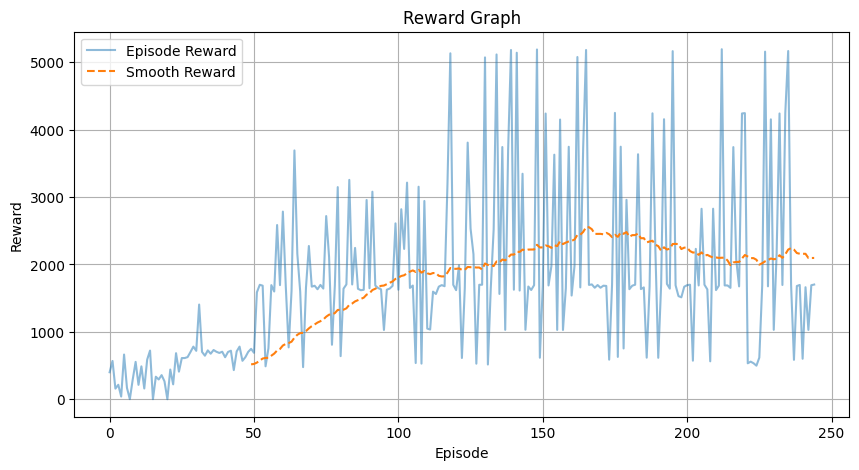

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
monitor_dir = f'../Logs/{Model}/{Model}_V{version}_S{num_episodes*max_steps_per_episode}.csv.monitor.csv'
df = pd.read_csv(monitor_dir, header=1)
plt.figure(figsize=(10, 5))
plt.plot(df['r'], label='Episode Reward', alpha=0.5)

# Calculate smooth reward (e.g., using a rolling mean)
window_size = 50  # You can adjust this window size
df['smooth_reward'] = df['r'].rolling(window=window_size).mean()
plt.plot(df['smooth_reward'], label=f'Smooth Reward', linestyle='--')

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward Graph')
plt.grid(True)
plt.legend()
plt.show()